## Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import ogr, gdal
from skimage.util.shape import view_as_windows
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import os
import ast

In [2]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Define Functions

In [3]:
def load_tiff_image(image):
    print (image)
    gdal_header = gdal.Open(image)
    img = gdal_header.ReadAsArray()
    return img

def normalization(image):
    return np.array(image)/127.5 - 1.

def extract_patches_test(binary_img_test_ref, patch_size):
    # Extract training patches
    stride = patch_size

    height, width = binary_img_test_ref.shape
    #print(height, width)

    num_patches_h = int(height / stride)
    num_patches_w = int(width / stride)
    #print(num_patches_h, num_patches_w)

    new_shape = (num_patches_h*num_patches_w, patch_size, patch_size)
    new_img_ref = np.zeros(new_shape)
    print(new_img_ref.shape)
    cont = 0
    # rows
    for h in range(num_patches_h):
        #columns
        for w in range(num_patches_w):
            new_img_ref[cont] = binary_img_test_ref[h*stride:(h+1)*stride, w*stride:(w+1)*stride]
            cont += 1
    #print(cont)
    
    return new_img_ref

def extract_patches_train(img_test_normalized, patch_size):
    # Extract training patches manual
    stride = patch_size

    height, width, channel = img_test_normalized.shape
    #print(height, width)

    num_patches_h = height // stride
    num_patches_w = width // stride
    #print(num_patches_h, num_patches_w)

    new_shape = (num_patches_h*num_patches_w, patch_size, patch_size, channel)
    new_img = np.zeros(new_shape)
    print(new_img.shape)
    cont = 0
    # rows
    for h in range(num_patches_h):
        # columns
        for w in range(num_patches_w):
            new_img[cont] = img_test_normalized[h*stride:(h+1)*stride, w*stride:(w+1)*stride]
            cont += 1
    #print(cont)

    
    return new_img

def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_class = np.argmax(result, axis=-1)
    return predicted_class

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    #avg_accuracy = 100*accuracy_score(true_labels, predicted_labels, average=None)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

## Load images

In [4]:
root_path = './'
# Load images
img_test_path = 'Image_Test.tif'
img_test = load_tiff_image(os.path.join(root_path, img_test_path)).astype(np.float32)
# Normalizes the image
img_test_normalized = normalization(img_test)
# Transform the image into W x H x C shape
img_test_normalized = img_test_normalized.transpose((1,2,0))
print(img_test_normalized.shape)

# Load reference
img_test_ref_path = 'Reference_Test.tif'
img_test_ref = load_tiff_image(os.path.join(root_path, img_test_ref_path))
img_test_ref = img_test_ref.transpose((1,2,0))
print(img_test_ref.shape)

./Image_Test.tif
(2558, 2818, 3)
./Reference_Test.tif
(2558, 2818, 3)


## Binarizes test image

In [5]:
# Create binarized matrix
w = img_test_ref.shape[0]
h = img_test_ref.shape[1]
c = img_test_ref.shape[2]
#binary_img_train_ref = np.zeros((1,w,h))
binary_img_test_ref = np.full((w,h), -1)
# Dictionary used in training
label_dict = {'(255, 255, 255)': 0, '(0, 255, 0)': 1, '(0, 255, 255)': 2, '(0, 0, 255)': 3, '(255, 255, 0)': 4}
label = 0
for i in range(w):
    for j in range(h):
        r = img_test_ref[i][j][0]
        g = img_test_ref[i][j][1]
        b = img_test_ref[i][j][2]
        rgb = (r,g,b)
        rgb_key = str(rgb)
        binary_img_test_ref[i][j] = label_dict[rgb_key]
print(label_dict)

0
{'(255, 255, 255)': 0, '(0, 255, 0)': 1, '(0, 255, 255)': 2, '(0, 0, 255)': 3, '(255, 255, 0)': 4}


## Extract Patches

In [6]:
# Put the patch size according to you training here
patch_size = 32
patches_test = extract_patches_train(img_test_normalized, patch_size)
patches_test_ref = extract_patches_test(binary_img_test_ref, patch_size)

(6952, 32, 32, 3)
(6952, 32, 32)


## Test model

In [7]:
# # load the model 
model = load_model('weights/best_model.h5', compile=False)

# Test the model 
patches_pred = Test(model, patches_test)
print(patches_pred.shape)

(6952, 32, 32)


## Metrics

In [8]:
true_labels = np.reshape(patches_test_ref, (patches_test_ref.shape[0]* patches_test_ref.shape[1]*patches_test_ref.shape[2]))
predicted_labels = np.reshape(patches_pred, (patches_pred.shape[0]* patches_pred.shape[1]*patches_pred.shape[2]))

In [10]:
# Metrics
metrics = compute_metrics(true_labels,predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2,3,4])

print('Confusion  matrix \n', cm)
print()
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix 
 [[ 940825   54436  118394   63977    2048]
 [  37377 1804061  250468   11868     100]
 [ 175919  748498 1429084  166149     690]
 [ 103380   16838  104042 1062509    1143]
 [  13067     226    5265    2003    6481]]

Accuracy:  73.64899489355581
F1score:  [76.79426736 76.31499854 64.55353959 81.90731023 34.56164676]
Recall:  [79.75256002 85.74947929 56.70203227 82.49857133 23.9664226 ]
Precision:  [74.04759131 68.75077885 74.92891609 81.32446388 61.94800229]


## Visualize patches

(-0.5, 31.5, 31.5, -0.5)

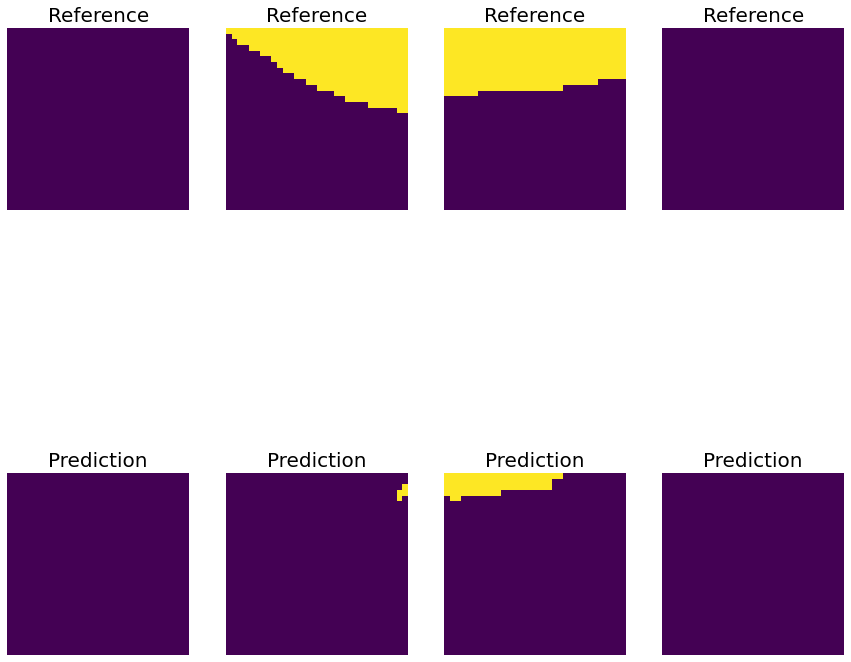

In [11]:
# # Plot the prediction
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7,ax8)) = plt.subplots(2, 4, figsize=(15, 15))
# Reference
ax1.imshow(patches_test_ref[10,:,:])
ax1.set_title('Reference', fontsize=20)
ax1.axis('off')
ax2.imshow(patches_test_ref[15,:,:])
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')
ax3.imshow(patches_test_ref[20,:,:])
ax3.set_title('Reference', fontsize=20)
ax3.axis('off')
ax4.imshow(patches_test_ref[23,:,:])
ax4.set_title('Reference', fontsize=20)
ax4.axis('off')

# Predictions
ax5.imshow(patches_pred[10,:,:])
ax5.set_title('Prediction', fontsize=20)
ax5.axis('off')
ax6.imshow(patches_pred[15,:,:])
ax6.set_title('Prediction', fontsize=20)
ax6.axis('off')
ax7.imshow(patches_pred[20,:,:])
ax7.set_title('Prediction', fontsize=20)
ax7.axis('off')
ax8.imshow(patches_pred[23,:,:])
ax8.set_title('Prediction', fontsize=20)
ax8.axis('off')

## Reconstruct prediction patches

In [12]:
def pred_recostruction(patch_size, pred_labels, binary_img_test_ref):
    # Patches Reconstruction
    stride = patch_size

    height, width = binary_img_test_ref.shape

    num_patches_h = height // stride
    num_patches_w = width // stride

    new_shape = (height, width)
    img_reconstructed = np.zeros(new_shape)
    cont = 0
    # rows
    for h in range(num_patches_h):
        # columns
        for w in range(num_patches_w):
            img_reconstructed[h*stride:(h+1)*stride, w*stride:(w+1)*stride] = patches_pred[cont]
            cont += 1
    print('Reconstruction Done!')
    return img_reconstructed

In [13]:
def reconstruction_rgb_prdiction_patches(img_reconstructed, label_dict):
    reversed_label_dict = {value : key for (key, value) in label_dict.items()}
    print(reversed_label_dict)
    height, width = img_reconstructed.shape
    img_reconstructed_rgb = np.zeros((height,width,3))
    for h in range(height):
        for w in range(width):
            pixel_class = img_reconstructed[h, w]
            img_reconstructed_rgb[h, w, :] = ast.literal_eval(reversed_label_dict[pixel_class])
    print('Conversion to RGB Done!')
    return img_reconstructed_rgb.astype(np.uint8)

In [14]:
img_reconstructed = pred_recostruction(patch_size, patches_pred, binary_img_test_ref)
img_reconstructed_rgb = reconstruction_rgb_prdiction_patches(img_reconstructed, label_dict)

Reconstruction Done!
{0: '(255, 255, 255)', 1: '(0, 255, 0)', 2: '(0, 255, 255)', 3: '(0, 0, 255)', 4: '(255, 255, 0)'}
Conversion to RGB Done!


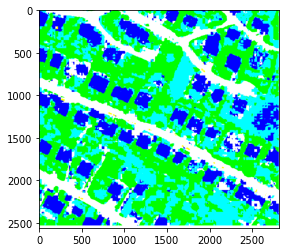

In [15]:
plt.imshow(img_reconstructed_rgb)

In [15]:
plt.imsave('img_reconstructed_rgb.jpeg', img_reconstructed_rgb)

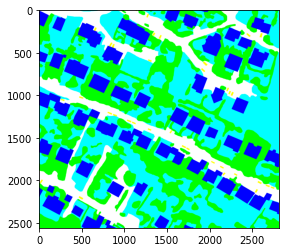

In [5]:
plt.imshow(img_test_ref)

In [6]:
plt.imsave('Reference_Test.jpeg', img_test_ref)

In [4]:
import numpy as np

In [7]:
x = list(range(0,16))
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
